In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,Dense,LSTM,SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

Using TensorFlow backend.


In [2]:
# Reading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [4]:
test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [5]:
# shape of train datset
train.shape

(7920, 3)

In [6]:
# shape of test datset
test.shape

(1953, 2)

In [7]:
# for checking the missing numbers
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7920 entries, 0 to 7919
Data columns (total 3 columns):
id       7920 non-null int64
label    7920 non-null int64
tweet    7920 non-null object
dtypes: int64(2), object(1)
memory usage: 185.7+ KB


In [8]:
# for checking the missing numbers
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 2 columns):
id       1953 non-null int64
tweet    1953 non-null object
dtypes: int64(1), object(1)
memory usage: 30.6+ KB


In [9]:
# Rename the columns
train.columns=['id','sentiment_type','tweet']

In [10]:
# Distribute the labels as positive and negative
positives = train['sentiment_type'][train.sentiment_type == 0]
negatives = train['sentiment_type'][train.sentiment_type == 1]

In [11]:
# Printing the labels
print('total number of Positives tagged sentences: {}'.format(len(positives)))
print('total number of negatives tagged sentences: {}'.format(len(negatives)))
print('total number of tagged sentences: {}'.format(train.shape[0]))

total number of Positives tagged sentences: 5894
total number of negatives tagged sentences: 2026
total number of tagged sentences: 7920


In [12]:
# For checking the balancing problem or not
train.sentiment_type.value_counts(normalize='True')   # Postive is 75% and negative is 25%

0    0.744192
1    0.255808
Name: sentiment_type, dtype: float64

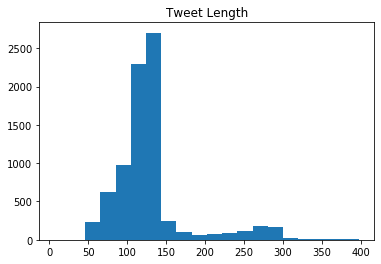

In [13]:
#Checking Distribution of length of the tweets or number of characters.
tweet_length= train.tweet.str.len()
plt.hist(tweet_length, bins=20)
plt.title("Tweet Length")
plt.show()

In [14]:
# Remove duplicates from dataset
df = train.drop_duplicates()
print('After removing duplicates, shape of train file is:',df.shape)  # It getting to be same.

After removing duplicates, shape of train file is: (7920, 3)


In [15]:
# Convert all tweets into lower format
train['tweet_up'] = train['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train.head()

,id,sentiment_type,tweet,tweet_up
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,#fingerprint #pregnancy test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally a transparant silicon case ^^ thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...,we love this! would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...,i'm wired i know i'm george i was made that wa...
4,5,1,What amazing service! Apple won't even talk to...,what amazing service! apple won't even talk to...


In [16]:
# Removing urls
train['tweet_up'] = train.tweet_up.apply(lambda x: re.sub("http\S+",' ',x))
train.head()

,id,sentiment_type,tweet,tweet_up
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,#fingerprint #pregnancy test #android #apps ...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally a transparant silicon case ^^ thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...,we love this! would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...,i'm wired i know i'm george i was made that wa...
4,5,1,What amazing service! Apple won't even talk to...,what amazing service! apple won't even talk to...


In [17]:
# removing twitter handles (i.e. @user_name)
train['tweet_up'] = train.tweet_up.apply(lambda x: re.sub("@[\w]*",'',x))
train.head()

,id,sentiment_type,tweet,tweet_up
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,#fingerprint #pregnancy test #android #apps ...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally a transparant silicon case ^^ thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...,we love this! would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...,i'm wired i know i'm george i was made that wa...
4,5,1,What amazing service! Apple won't even talk to...,what amazing service! apple won't even talk to...


In [18]:
# Removing Punctuation mark
train['tweet_up'] = train.tweet_up.apply(lambda x: re.sub("[^a-z\s]",'',x))
train.head()

,id,sentiment_type,tweet,tweet_up
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beau...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally a transparant silicon case thanks to ...
2,3,0,We love this! Would you go? #talk #makememorie...,we love this would you go talk makememories un...
3,4,0,I'm wired I know I'm George I was made that wa...,im wired i know im george i was made that way ...
4,5,1,What amazing service! Apple won't even talk to...,what amazing service apple wont even talk to m...


In [19]:
appos = {"aren't" : "are not","can't" : "cannot","couldn't" : "could not","didn't" : "did not","doesn't" : "does not",
"don't" : "do not","hadn't" : "had not","hasn't" : "has not","haven't" : "have not","he'd" : "he would","he'll" : "he will",
"he's" : "he is","i'd" : "i would","i'd" : "i had","i'll" : "i will","i'm" : "i am","isn't" : "is not","it's" : "it is",
"it'll":"it will","i've" : "i have","let's" : "let us","mightn't" : "might not","mustn't" : "must not","shan't" : "shall not",
"she'd" : "she would","she'll" : "she will","she's" : "she is","shouldn't" : "should not","that's" : "that is","there's" : "there is",
"they'd" : "they would","they'll" : "they will","they're" : "they are","they've" : "they have","we'd" : "we would",
"we're" : "we are","weren't" : "were not","we've" : "we have","what'll" : "what will","what're" : "what are",
"what's" : "what is","what've" : "what have","where's" : "where is","who'd" : "who would","who'll" : "who will",
"who're" : "who are","who's" : "who is","who've" : "who have","won't" : "will not","wouldn't" : "would not",
"you'd" : "you would","you'll" : "you will","you're" : "you are","you've" : "you have","'re": " are","wasn't": "was not",
"we'll":" will","didn't": "did not"}

In [20]:
# Apostrophes Handling
train['tweet_up'] = train['tweet_up'].apply(lambda x: " ".join(appos[x] if x in appos else x for x in x.split()))
train.head()

,id,sentiment_type,tweet,tweet_up
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beauti...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally a transparant silicon case thanks to m...
2,3,0,We love this! Would you go? #talk #makememorie...,we love this would you go talk makememories un...
3,4,0,I'm wired I know I'm George I was made that wa...,im wired i know im george i was made that way ...
4,5,1,What amazing service! Apple won't even talk to...,what amazing service apple wont even talk to m...


In [21]:
# Removing Stopwords
# from nltk.corpus import stopwords
stop = stopwords.words('english')
train['tweet_up'] = train['tweet_up'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train.head()

,id,sentiment_type,tweet,tweet_up
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beauti...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks uncle ...
2,3,0,We love this! Would you go? #talk #makememorie...,love would go talk makememories unplug relax i...
3,4,0,I'm wired I know I'm George I was made that wa...,im wired know im george made way iphone cute d...
4,5,1,What amazing service! Apple won't even talk to...,amazing service apple wont even talk question ...


In [22]:
# Remove character having length less than 2
train['tweet_up'] = train['tweet_up'].apply(lambda x: " ".join([a for a in x.split() if len(a)>2]))
train.head()

,id,sentiment_type,tweet,tweet_up
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beauti...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks uncle ...
2,3,0,We love this! Would you go? #talk #makememorie...,love would talk makememories unplug relax ipho...
3,4,0,I'm wired I know I'm George I was made that wa...,wired know george made way iphone cute daventr...
4,5,1,What amazing service! Apple won't even talk to...,amazing service apple wont even talk question ...


In [23]:
# if preinstall then not do this step
# nltk.download('punkt')

In [24]:
# Tokenization on tweet_up
train['tweet_up'] = train['tweet_up'].apply(lambda x: word_tokenize(x))
train.head()

,id,sentiment_type,tweet,tweet_up
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,"[fingerprint, pregnancy, test, android, apps, ..."
1,2,0,Finally a transparant silicon case ^^ Thanks t...,"[finally, transparant, silicon, case, thanks, ..."
2,3,0,We love this! Would you go? #talk #makememorie...,"[love, would, talk, makememories, unplug, rela..."
3,4,0,I'm wired I know I'm George I was made that wa...,"[wired, know, george, made, way, iphone, cute,..."
4,5,1,What amazing service! Apple won't even talk to...,"[amazing, service, apple, wont, even, talk, qu..."


In [25]:
# nltk.download('wordnet')

In [26]:
# Lemmatization on tweet_up
train['tweet_up'] = train['tweet_up'].apply(lambda x: [WordNetLemmatizer().lemmatize(i,'a') for i in x])
train.head()

,id,sentiment_type,tweet,tweet_up
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,"[fingerprint, pregnancy, test, android, apps, ..."
1,2,0,Finally a transparant silicon case ^^ Thanks t...,"[finally, transparant, silicon, case, thanks, ..."
2,3,0,We love this! Would you go? #talk #makememorie...,"[love, would, talk, makememories, unplug, rela..."
3,4,0,I'm wired I know I'm George I was made that wa...,"[wired, know, george, made, way, iphone, cute,..."
4,5,1,What amazing service! Apple won't even talk to...,"[amazing, service, apple, wont, even, talk, qu..."


In [27]:
# Stitching of tokens back together
for i in range(len(train['tweet_up'])):
    train['tweet_up'][i] = ' '.join(train['tweet_up'][i])
train.head()

,id,sentiment_type,tweet,tweet_up
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...,fingerprint pregnancy test android apps beauti...
1,2,0,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks uncle ...
2,3,0,We love this! Would you go? #talk #makememorie...,love would talk makememories unplug relax ipho...
3,4,0,I'm wired I know I'm George I was made that wa...,wired know george made way iphone cute daventr...
4,5,1,What amazing service! Apple won't even talk to...,amazing service apple wont even talk question ...


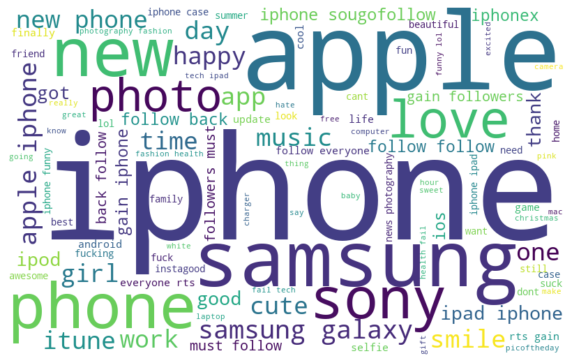

In [28]:
# Story generation and visualization of tweets
words = ' '.join([b for b in train.tweet_up])
wordc = WordCloud(width=800,height=500,random_state=21,max_words=100,background_color="White").generate(words)
plt.figure(figsize = (10,7))
plt.imshow(wordc,interpolation='bilinear')
plt.axis('off')
plt.show()

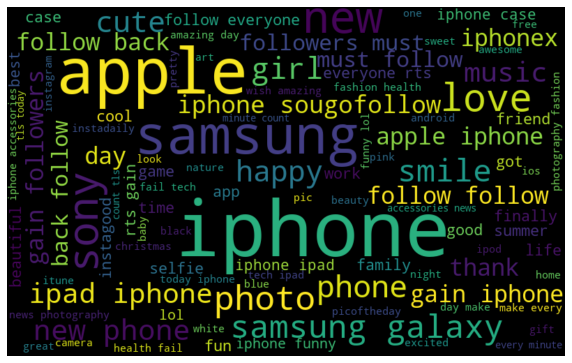

In [31]:
# most common words in positive tweets
positive_words =' '.join([t for t in train['tweet_up'][train['sentiment_type'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21,max_words=100,max_font_size=110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

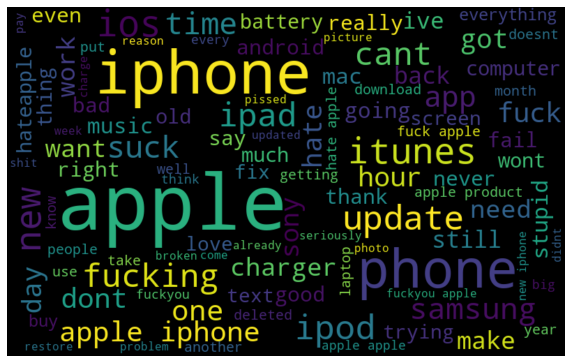

In [32]:
# most common words in negative tweets
negative_words =' '.join([t for t in train['tweet_up'][train['sentiment_type'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21,max_words=100,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [35]:
# feature extraction from tweets
# split the dataset in 80% and 20% format.
from sklearn.model_selection import train_test_split
x = train['tweet_up']
y = train['sentiment_type']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,shuffle=True,stratify=y)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(6336,) (6336,)
(1584,) (1584,)


In [37]:
# Bag of words (or one-hot-encoding)
# by initialise the bow_vector
import joblib
bow = CountVectorizer(binary=True)
# for fit training dataset into bow
bow.fit(x_train)
# save the vectorizer in disk
joblib.dump(bow,'bow_vectorizer')
# Load the vectorizer from disk
load = joblib.load('bow_vectorizer')

# Initialise the bow_vectorizer
load_train = load.transform(x_train)
load_test = load.transform(x_test)

In [38]:
# Model Building 
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42,class_weight='balanced')
#Fitting the training model
lr.fit(load_train,y_train)
# Predicting the model
lr_predict = lr.predict(load_test)
# save the model to disk
joblib.dump(lr,'trained LR model')

['trained LR model']

In [39]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix

In [42]:
print('Confusion Matrix of LR: \n',confusion_matrix(y_test,lr_predict))
print('Accuracy Score of LR: \n',accuracy_score(y_test,lr_predict))
print('Precision Score of LR: \n',precision_score(y_test,lr_predict))
print('Recall Scoreof LR: \n',recall_score(y_test,lr_predict))
print('Classification Repost of LR: \n',classification_report(y_test,lr_predict))
f1score = f1_score(y_test,lr_predict,pos_label=0) # for only positive value
print('F1 Score of LR: %.2f'%(f1score))

Confusion Matrix of LR: 
 [[1069  110]
 [  59  346]]
Accuracy Score of LR: 
 0.8933080808080808
Precision Score of LR: 
 0.7587719298245614
Recall Scoreof LR: 
 0.854320987654321
Classification Repost of LR: 
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      1179
           1       0.76      0.85      0.80       405

    accuracy                           0.89      1584
   macro avg       0.85      0.88      0.87      1584
weighted avg       0.90      0.89      0.90      1584

F1 Score of LR: 0.93


In [43]:
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(random_state=42,class_weight='balanced')
#Fitting the training model
rf.fit(load_train,y_train)
# Predicting the model
rf_predict = rf.predict(load_test)
# save the model to disk
joblib.dump(rf,'trained RF model')

['trained RF model']

In [44]:
print('Confusion Matrix of RF: \n',confusion_matrix(y_test,rf_predict))
print('Accuracy Score of RF: \n',accuracy_score(y_test,rf_predict))
print('Precision Score of RF: \n',precision_score(y_test,rf_predict))
print('Recall Scoreof RF: \n',recall_score(y_test,rf_predict))
print('Classification Repost of RF: \n',classification_report(y_test,rf_predict))
f1score = f1_score(y_test,rf_predict,pos_label=0) # for only positive value
print('F1 Score of RF: %.2f'%(f1score))

Confusion Matrix of RF: 
 [[1102   77]
 [ 147  258]]
Accuracy Score of RF: 
 0.8585858585858586
Precision Score of RF: 
 0.7701492537313432
Recall Scoreof RF: 
 0.6370370370370371
Classification Repost of RF: 
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      1179
           1       0.77      0.64      0.70       405

    accuracy                           0.86      1584
   macro avg       0.83      0.79      0.80      1584
weighted avg       0.85      0.86      0.85      1584

F1 Score of RF: 0.91


In [45]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,class_weight='balanced')
#Fitting the training model
dt.fit(load_train,y_train)
# Predicting the model
dt_predict = dt.predict(load_test)
# save the model to disk
joblib.dump(dt,'trained DT model')

['trained DT model']

In [46]:
print('Confusion Matrix of DT: \n',confusion_matrix(y_test,dt_predict))
print('Accuracy Score of DT: \n',accuracy_score(y_test,dt_predict))
print('Precision Score of DT: \n',precision_score(y_test,dt_predict))
print('Recall Scoreof DT: \n',recall_score(y_test,dt_predict))
print('Classification Repost of DT: \n',classification_report(y_test,dt_predict))
f1score = f1_score(y_test,dt_predict,pos_label=0) # for only positive value
# f1score = f1_score(y_test,dt_predict,neg_label=1) # for only negative value
print('F1 Score of DT: %.2f'%(f1score))

Confusion Matrix of DT: 
 [[1032  147]
 [ 119  286]]
Accuracy Score of DT: 
 0.8320707070707071
Precision Score of DT: 
 0.6605080831408776
Recall Scoreof DT: 
 0.7061728395061728
Classification Repost of DT: 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1179
           1       0.66      0.71      0.68       405

    accuracy                           0.83      1584
   macro avg       0.78      0.79      0.78      1584
weighted avg       0.84      0.83      0.83      1584

F1 Score of DT: 0.89


In [ ]:
# After per